# Simple Ray Tracing

This notebook implements the basic concepts of Ray Tracing step by step.

### Learning Steps
1. **Window Creation** - Basic canvas setup
2. **Vector2D & Basic Shapes** - Draw a single circle
3. **Multiple Objects** - Circle, Triangle, Rectangle
4. **Mouse Interaction** - Move objects
5. **Ray Generation** - Draw rays
6. **Light Source System** - Real-time rendering
7. **Intersection** - Ray intersection and shadows
8. **Secondary Ray Generation** - Secondary ray

# Imports library

We only use python standard library without third-party framework

In [43]:
import tkinter as tk
from math import sqrt, cos, sin, pi
from typing import Optional, List, Tuple

---
# Step 1: Window Creation and Basic Setup

A **canvas** is a drawing surface where we can render graphics. In this step, we create a black background canvas using tkinter, Python's standard GUI library.

**Key Concepts:**
- Window: The application frame
- Canvas: Drawing area where all graphics are rendered
- Coordinate System: Origin (0,0) is at top-left, x increases right, y increases down

In [ ]:
# Step 1: Display empty window
class Generate_Window:
    def __init__(self) -> None:
        self.root = tk.Tk()
        self.root.title("Step 1: Window Generation")
        
        # Canvas setup
        self.width: int = 1000
        self.height: int = 700
        self.canvas = tk.Canvas(self.root, width=self.width, height=self.height, bg='black')
        self.canvas.pack()
        
        self.root.mainloop()

# Generate_Window()

We can see the empty canvas

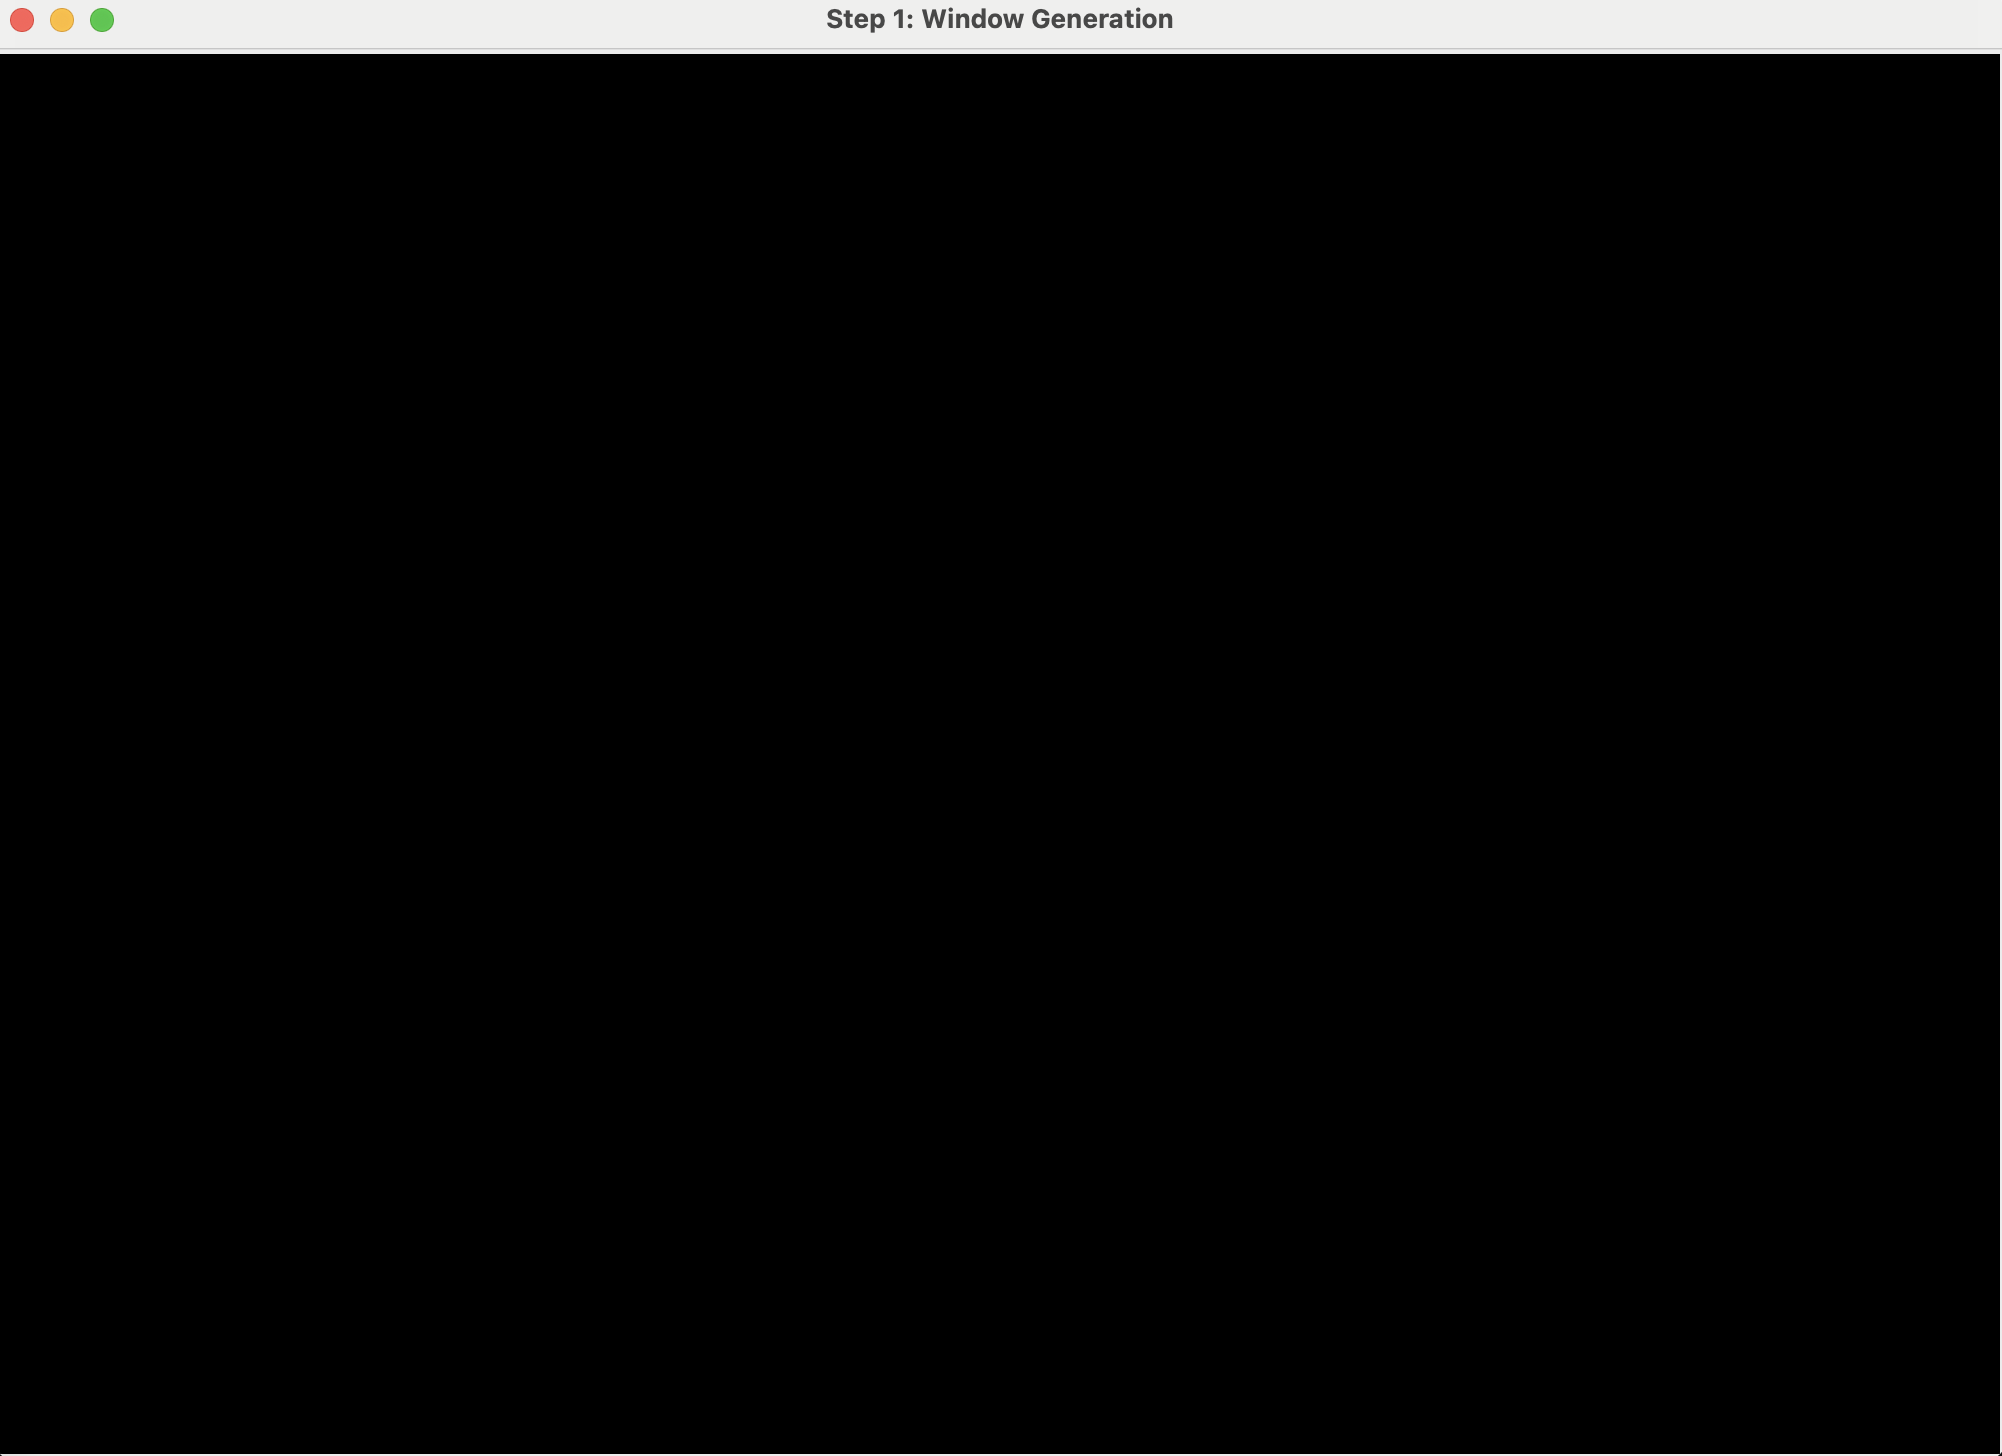

---
# Step 2: Vector2D Class and Drawing a Circle

**Vectors** are fundamental in computer graphics. A 2D vector represents a point in space or a direction.

**Vector Operations:**
- **Addition (v1 + v2)**: Combine two vectors
- **Subtraction (v1 - v2)**: Get direction from v2 to v1
- **Scalar Multiplication (v * s)**: Scale vector by factor s
- **Dot Product (v1 · v2)**: Projects one vector onto another, returns scalar
- **Length**: Magnitude of vector, calculated as √(x² + y²)
- **Normalization**: Convert to unit vector (length = 1), preserving direction

**Why Vectors?**
In ray tracing, we use vectors to represent:
- Positions (where objects are)
- Directions (where rays travel)
- Velocities (how objects move)

In [46]:
class Vector2D:
    """2D Vector class - represents position and direction"""

    def __init__(self, x: float = 0.0, y: float = 0.0) -> None:
        self.x = x
        self.y = y

    def __add__(self, other: 'Vector2D') -> 'Vector2D':
        """Vector addition: v1 + v2"""
        return Vector2D(self.x + other.x, self.y + other.y)

    def __sub__(self, other: 'Vector2D') -> 'Vector2D':
        """Vector subtraction: v1 - v2"""
        return Vector2D(self.x - other.x, self.y - other.y)

    def __mul__(self, scalar: float) -> 'Vector2D':
        """Scalar multiplication: v * scalar"""
        return Vector2D(self.x * scalar, self.y * scalar)

    def __truediv__(self, scalar: float) -> 'Vector2D':
        """Scalar division: v / scalar"""
        return Vector2D(self.x / scalar, self.y / scalar)

    def dot(self, other: 'Vector2D') -> float:
        """Dot product: v1 · v2 = |v1||v2|cosθ"""
        return self.x * other.x + self.y * other.y

    def length(self) -> float:
        """Calculate vector length (magnitude)"""
        return sqrt(self.x * self.x + self.y * self.y)

    def length_squared(self) -> float:
        """Squared length (for performance optimization)"""
        return self.x * self.x + self.y * self.y

    def normalize(self) -> 'Vector2D':
        """Normalize: convert to unit vector (length = 1)"""
        length = self.length()
        if length > 0:
            return self / length
        return Vector2D(0, 0)

    def __repr__(self) -> str:
        return f"Vector2D({self.x:.2f}, {self.y:.2f})"

In [ ]:
# Step 2: Draw a single circle
class BasicShape:
    def __init__(self) -> None:
        self.root = tk.Tk()
        self.root.title("Step 2: Basic Shape")
        
        self.width: int = 1000
        self.height: int = 700
        self.canvas = tk.Canvas(self.root, width=self.width, height=self.height, bg='black')
        self.canvas.pack()
        
        # Draw a circle
        center = Vector2D(500, 350)
        radius = 100
        self.canvas.create_oval(
            center.x - radius, center.y - radius,
            center.x + radius, center.y + radius,
            outline='cyan', fill='cyan', width=2
        )
        
        self.root.mainloop()

# BasicShape()

We can see the circle which can be objects or light source in the canvas.

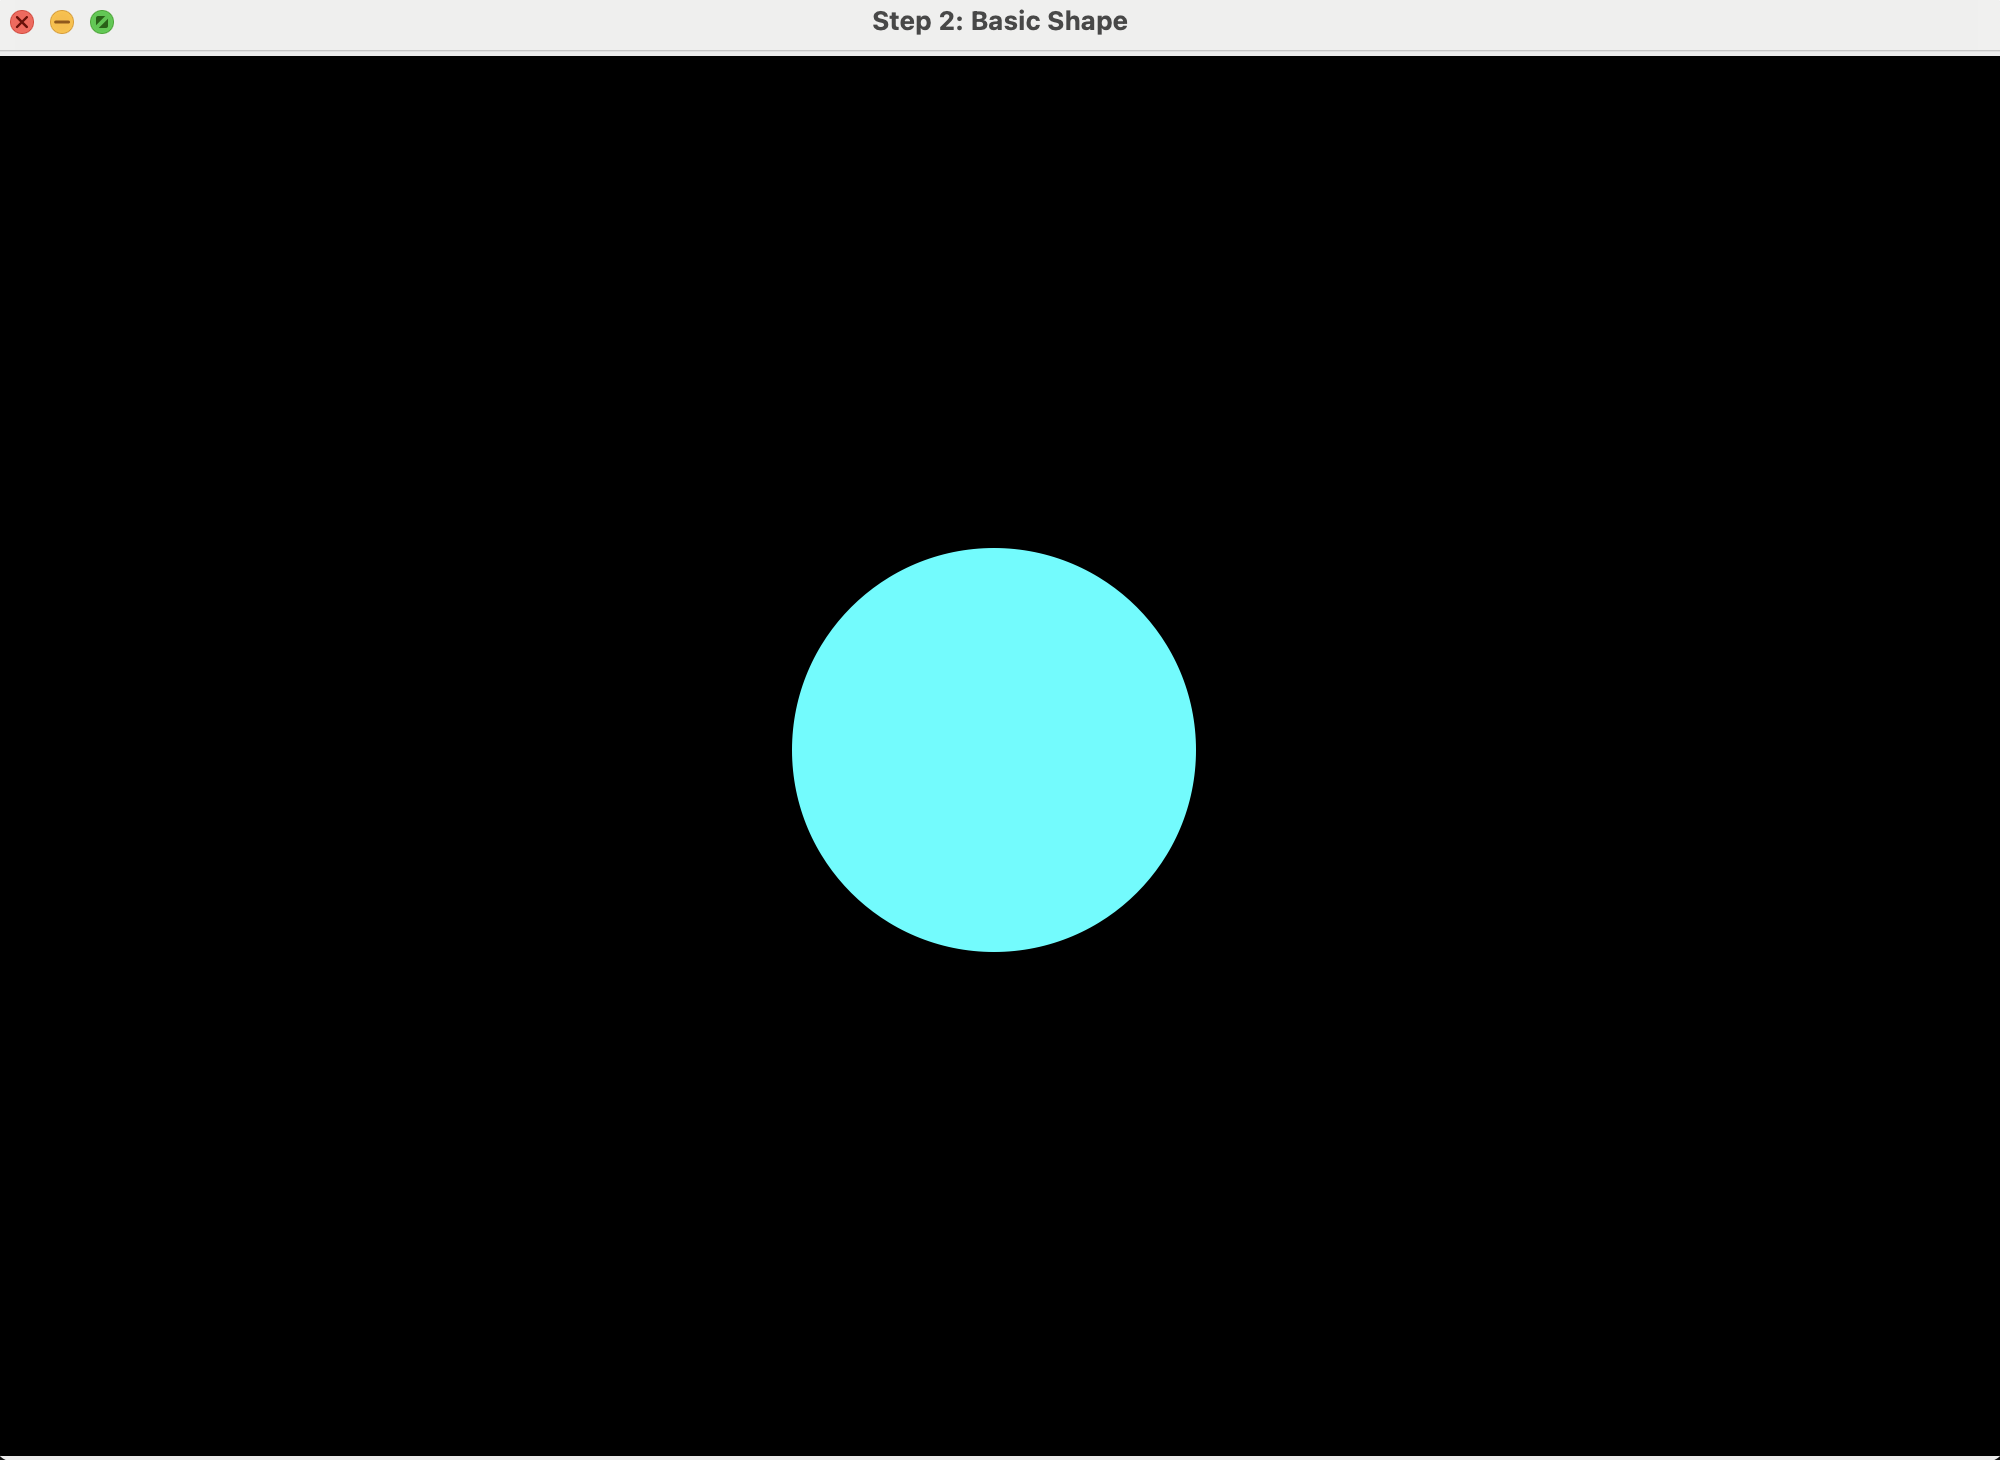

---
# Step 3: Objects (Circle, Triangle, Rectangle)

In ray tracing, we need to represent different types of geometric shapes. Each shape has:
- **Position**: Where the shape is located
- **Dimensions**: Size/vertices of the shape
- **Containment Test**: Method to check if a point is inside the shape

**Objects:**
- **Circle**: Defined by center point and radius
- **Triangle**: Defined by three vertices (p1, p2, p3)
- **Rectangle**: Defined by center, width, and height (axis-aligned)

**Point-in-Shape Testing:**
- **Circle**: Distance from point to center ≤ radius
- **Triangle**: Barycentric coordinates method
- **Rectangle**: Check if point is within x and y bounds

In [ ]:
class Circle:
    """Circle"""
    def __init__(self, center: Vector2D, radius: float, color: str = 'white') -> None:
        self.center = center
        self.radius = radius
        self.color = color
    
    def contains_point(self, point: Vector2D) -> bool:
        """Check if a point is inside the circle"""
        return (point - self.center).length() <= self.radius
    
    def __repr__(self) -> str:
        return f"Circle(center={self.center}, radius={self.radius})"


class Triangle:
    """Triangle"""
    def __init__(self, p1: Vector2D, p2: Vector2D, p3: Vector2D, color: str = 'white') -> None:
        self.p1 = p1
        self.p2 = p2
        self.p3 = p3
        self.color = color
        # Calculate centroid
        self.center = Vector2D(
            (p1.x + p2.x + p3.x) / 3,
            (p1.y + p2.y + p3.y) / 3
        )
    
    def contains_point(self, point: Vector2D) -> bool:
        """Check if a point is inside the triangle (using barycentric coordinates)"""
        v0 = self.p3 - self.p1
        v1 = self.p2 - self.p1
        v2 = point - self.p1
        
        dot00 = v0.dot(v0)
        dot01 = v0.dot(v1)
        dot02 = v0.dot(v2)
        dot11 = v1.dot(v1)
        dot12 = v1.dot(v2)
        
        inv_denom = 1 / (dot00 * dot11 - dot01 * dot01)
        u = (dot11 * dot02 - dot01 * dot12) * inv_denom
        v = (dot00 * dot12 - dot01 * dot02) * inv_denom
        
        return (u >= 0) and (v >= 0) and (u + v <= 1)
    
    def move(self, delta: Vector2D) -> None:
        """Move triangle by delta vector"""
        self.p1 = self.p1 + delta
        self.p2 = self.p2 + delta
        self.p3 = self.p3 + delta
        self.center = self.center + delta
    
    def __repr__(self) -> str:
        return f"Triangle(p1={self.p1}, p2={self.p2}, p3={self.p3})"


class Rectangle:
    """Rectangle (axis-aligned)"""
    def __init__(self, center: Vector2D, width: float, height: float, color: str = 'white') -> None:
        self.center = center
        self.width = width
        self.height = height
        self.color = color
    
    def contains_point(self, point: Vector2D) -> bool:
        """Check if a point is inside the rectangle"""
        half_w = self.width / 2
        half_h = self.height / 2
        return (abs(point.x - self.center.x) <= half_w and 
                abs(point.y - self.center.y) <= half_h)
    
    def __repr__(self) -> str:
        return f"Rectangle(center={self.center}, width={self.width}, height={self.height})"

In [ ]:
# Step 3: Draw multiple shapes
class MultipleObjects:
    def __init__(self) -> None:
        self.root = tk.Tk()
        self.root.title("Step 3: Multiple Objects")
        
        self.width: int = 1000
        self.height: int = 700
        self.canvas = tk.Canvas(self.root, width=self.width, height=self.height, bg='black')
        self.canvas.pack()
        
        # Create various shapes
        self.create_objects()
        self.draw_all()
        
        self.root.mainloop()
    
    def create_objects(self) -> None:
        """Create multiple shapes"""
        self.circle = Circle(Vector2D(300, 350), 80, 'cyan')
        self.triangle = Triangle(
            Vector2D(600, 250),
            Vector2D(700, 450),
            Vector2D(500, 450),
            'magenta'
        )
        self.rectangle = Rectangle(Vector2D(800, 350), 150, 100, 'yellow')
    
    def draw_all(self) -> None:
        """Draw all shapes"""
        # Draw circle
        x, y = self.circle.center.x, self.circle.center.y
        r = self.circle.radius
        self.canvas.create_oval(
            x - r, y - r, x + r, y + r,
            outline=self.circle.color, fill=self.circle.color, width=2
        )
        
        # Draw triangle
        self.canvas.create_polygon(
            self.triangle.p1.x, self.triangle.p1.y,
            self.triangle.p2.x, self.triangle.p2.y,
            self.triangle.p3.x, self.triangle.p3.y,
            outline=self.triangle.color, fill=self.triangle.color, width=2
        )
        
        # Draw rectangle
        x, y = self.rectangle.center.x, self.rectangle.center.y
        w, h = self.rectangle.width / 2, self.rectangle.height / 2
        self.canvas.create_rectangle(
            x - w, y - h, x + w, y + h,
            outline=self.rectangle.color, fill=self.rectangle.color, width=2
        )

# MultipleObjects()

We can see the objects.



---
# Step 4: Mouse Interaction - Moving Objects

**Event-Driven Programming**: Respond to user input events (mouse clicks, drags, releases).

**Mouse Events:**
- `<Button-1>`: Left mouse button pressed
- `<B1-Motion>`: Mouse moved while left button held (drag)
- `<ButtonRelease-1>`: Left mouse button released

**Real-time Rendering Loop:**
Instead of drawing once, we continuously refresh the display (~60 FPS) to show smooth motion.

**Implementation:**
1. Detect which object is clicked using `contains_point()`
2. Track mouse position during drag
3. Update object position
4. Redraw everything each frame

In [ ]:
# Step 4: Move objects with mouse
from typing import Union

class Interactive_ObjectMovement:
    def __init__(self) -> None:
        self.root = tk.Tk()
        self.root.title("Step 4: Mouse Interaction")
        
        self.width: int = 1000
        self.height: int = 700
        self.canvas = tk.Canvas(self.root, width=self.width, height=self.height, bg='black')
        self.canvas.pack()
        
        # Create shapes
        self.create_objects()
        
        # Mouse drag state
        self.dragging_object: Optional[Union[Circle, Triangle, Rectangle]] = None
        self.drag_offset: Vector2D = Vector2D()
        
        # Bind mouse events
        self.canvas.bind("<Button-1>", self.on_mouse_press)
        self.canvas.bind("<B1-Motion>", self.on_mouse_drag)
        self.canvas.bind("<ButtonRelease-1>", self.on_mouse_release)
        
        # Real-time rendering
        self.update()
        self.root.mainloop()
    
    def create_objects(self) -> None:
        """Create multiple shapes"""
        self.circle = Circle(Vector2D(300, 350), 80, 'cyan')
        self.triangle = Triangle(
            Vector2D(600, 250),
            Vector2D(700, 450),
            Vector2D(500, 450),
            'magenta'
        )
        self.rectangle = Rectangle(Vector2D(800, 350), 150, 100, 'yellow')
        self.objects = [self.circle, self.triangle, self.rectangle]
    
    def on_mouse_press(self, event: tk.Event) -> None:
        """Mouse click - detect which shape is selected"""
        mouse_pos = Vector2D(event.x, event.y)
        
        # Check in reverse order (top to bottom)
        for obj in reversed(self.objects):
            if obj.contains_point(mouse_pos):
                self.dragging_object = obj
                self.drag_offset = mouse_pos - obj.center
                break
    
    def on_mouse_drag(self, event: tk.Event) -> None:
        """Mouse drag - move the shape"""
        if self.dragging_object:
            mouse_pos = Vector2D(event.x, event.y)
            new_center = mouse_pos - self.drag_offset
            
            if isinstance(self.dragging_object, Triangle):
                # Triangle uses move method
                delta = new_center - self.dragging_object.center
                self.dragging_object.move(delta)
            else:
                # Circle and Rectangle can directly update center
                self.dragging_object.center = new_center
    
    def on_mouse_release(self, event: tk.Event) -> None:
        """Mouse release - stop dragging"""
        self.dragging_object = None
    
    def draw_all(self) -> None:
        """Draw all shapes"""
        # Draw circle
        x, y = self.circle.center.x, self.circle.center.y
        r = self.circle.radius
        self.canvas.create_oval(
            x - r, y - r, x + r, y + r,
            outline=self.circle.color, fill=self.circle.color, width=2
        )
        
        # Draw triangle
        self.canvas.create_polygon(
            self.triangle.p1.x, self.triangle.p1.y,
            self.triangle.p2.x, self.triangle.p2.y,
            self.triangle.p3.x, self.triangle.p3.y,
            outline=self.triangle.color, fill=self.triangle.color, width=2
        )
        
        # Draw rectangle
        x, y = self.rectangle.center.x, self.rectangle.center.y
        w, h = self.rectangle.width / 2, self.rectangle.height / 2
        self.canvas.create_rectangle(
            x - w, y - h, x + w, y + h,
            outline=self.rectangle.color, fill=self.rectangle.color, width=2
        )
    
    def update(self) -> None:
        """Real-time rendering"""
        self.canvas.delete("all")
        self.draw_all()
        self.root.after(16, self.update)  # ~60fps

# Interactive_ObjectMovement()

We can move the objects.



---
# Step 5: Draw Rays

A **ray** is a half-line that starts at an origin point and extends infinitely in a direction.

**Ray Equation:** `P(t) = Origin + t * Direction`
- `Origin`: Starting point of the ray
- `Direction`: Normalized vector indicating ray direction
- `t`: Distance parameter (t ≥ 0)
- `P(t)`: Any point along the ray

**In Ray Tracing:**
- Light sources emit rays in all directions
- We trace these rays to see what they hit
- Multiple rays create realistic lighting and shadows

In [64]:
class Ray:
    """Generate rays - defined by origin and direction"""

    def __init__(self, origin: Vector2D, direction: Vector2D) -> None:
        self.origin = origin  # Ray starting point
        self.direction = direction.normalize()  # Ray direction (auto-normalized)

    def point_at(self, t: float) -> Vector2D:
        """Point on ray: P(t) = origin + t * direction"""
        return self.origin + self.direction * t

    def __repr__(self) -> str:
        return f"Ray(origin={self.origin}, direction={self.direction})"

In [ ]:
# Step 5: Shoot rays from a point
class Draw_Rays:
    def __init__(self) -> None:
        self.root = tk.Tk()
        self.root.title("Step 5: Ray Drawing")
        
        self.width: int = 1000
        self.height: int = 700
        self.canvas = tk.Canvas(self.root, width=self.width, height=self.height, bg='black')
        self.canvas.pack()
        
        # Ray origin
        self.ray_origin = Vector2D(200, 350)
        
        # Generate rays (in all directions)
        self.rays: List[Ray] = []
        num_rays = 120
        for i in range(num_rays):
            angle = 2 * pi * i / num_rays
            direction = Vector2D(cos(angle), sin(angle))
            self.rays.append(Ray(self.ray_origin, direction))
        
        self.draw_all()
        self.root.mainloop()
    
    def draw_all(self) -> None:
        """Draw rays and origin point"""
        # Draw rays
        for ray in self.rays:
            end = ray.point_at(1000)  # Ray length
            self.canvas.create_line(
                ray.origin.x, ray.origin.y,
                end.x, end.y,
                fill='yellow', width=1
            )
        
        # Draw origin point
        r = 20
        self.canvas.create_oval(
            self.ray_origin.x - r, self.ray_origin.y - r,
            self.ray_origin.x + r, self.ray_origin.y + r,
            outline='red', fill='red', width=2
        )

# Draw_Rays()

We can see the rays from the light source.

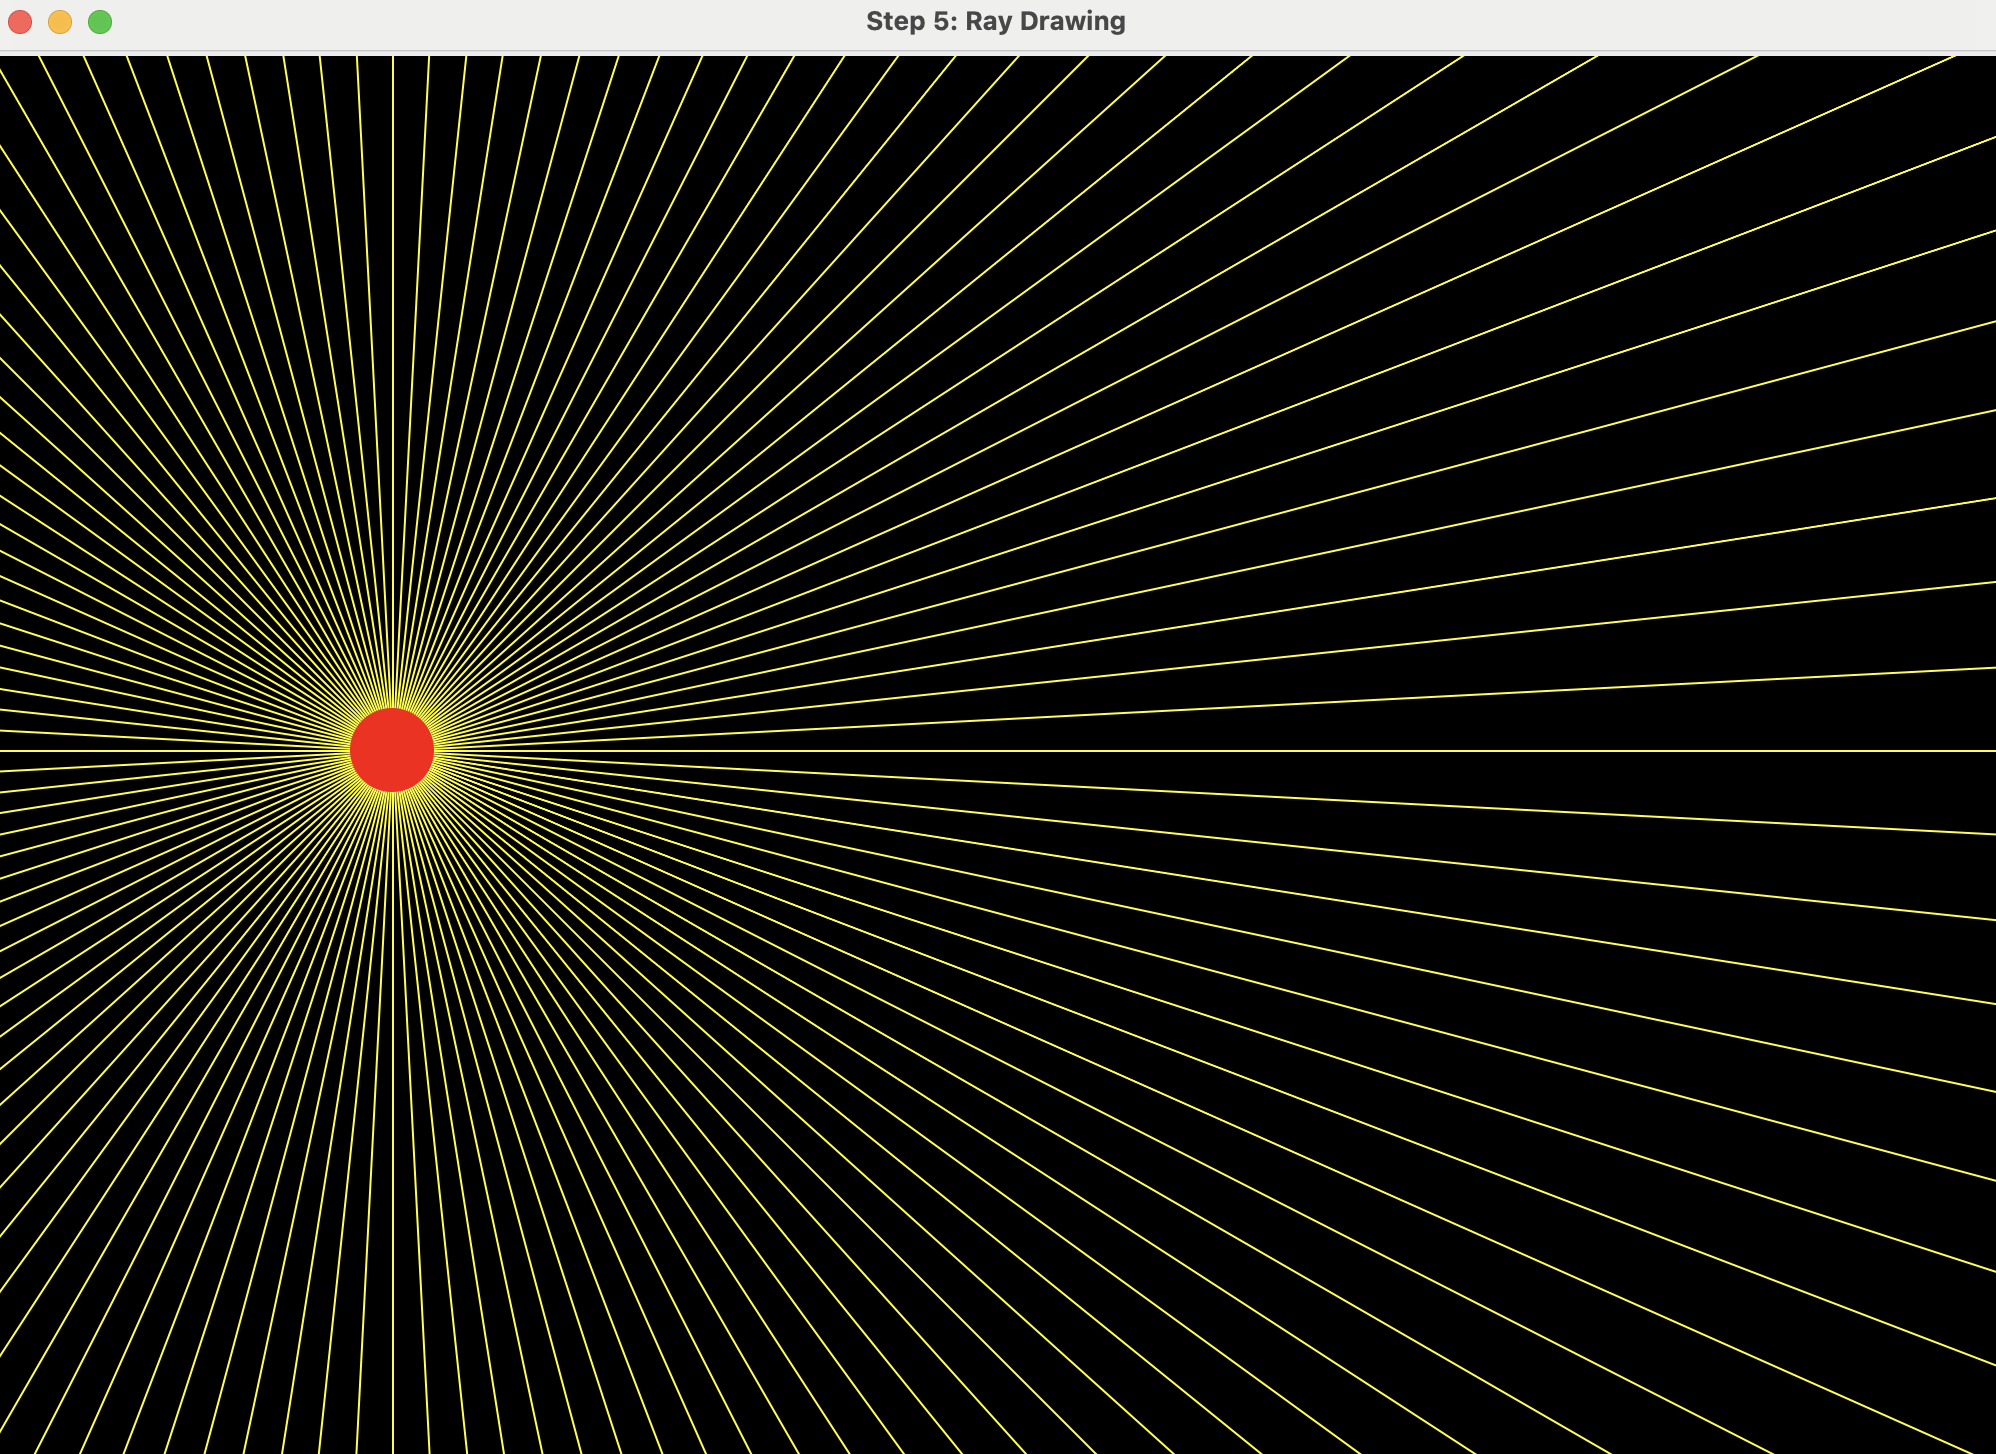

---
# Step 6: Light Source System - Real-time Rendering

Combine light source with objects to create a complete scene.

**Light Source:**
- Emits rays in all directions (360°)
- When moved, rays are regenerated in real-time
- Forms the basis for shadow calculations

**Interactive Scene:**
- Drag light source: Rays follow the light
- Drag objects: Move obstacles in the light path
- Real-time updates show immediate feedback

In [ ]:
# Step 6: Light source with objects
class LightSource_WithObjects:
    def __init__(self) -> None:
        self.root = tk.Tk()
        self.root.title("Step 6: Light Source System")
        
        self.width: int = 1000
        self.height: int = 700
        self.canvas = tk.Canvas(self.root, width=self.width, height=self.height, bg='black')
        self.canvas.pack()
        
        # Light source
        self.light_pos = Vector2D(200, 350)
        self.light_radius = 20
        
        # Create shapes
        self.create_objects()
        
        # Generate rays
        self.generate_rays()
        
        # Mouse drag state
        self.dragging_light: bool = False
        self.dragging_object: Optional[Union[Circle, Triangle, Rectangle]] = None
        self.drag_offset: Vector2D = Vector2D()
        
        # Bind mouse events
        self.canvas.bind("<Button-1>", self.on_mouse_press)
        self.canvas.bind("<B1-Motion>", self.on_mouse_drag)
        self.canvas.bind("<ButtonRelease-1>", self.on_mouse_release)
        
        # Real-time rendering
        self.update()
        self.root.mainloop()
    
    def create_objects(self) -> None:
        """Create multiple shapes"""
        self.circle = Circle(Vector2D(500, 350), 80, 'cyan')
        self.triangle = Triangle(
            Vector2D(750, 250),
            Vector2D(850, 450),
            Vector2D(650, 450),
            'magenta'
        )
        self.rectangle = Rectangle(Vector2D(700, 200), 100, 80, 'yellow')
        self.objects = [self.circle, self.triangle, self.rectangle]
    
    def generate_rays(self) -> None:
        """Generate rays from light source"""
        self.rays: List[Ray] = []
        num_rays = 120
        for i in range(num_rays):
            angle = 2 * pi * i / num_rays
            direction = Vector2D(cos(angle), sin(angle))
            self.rays.append(Ray(self.light_pos, direction))
    
    def on_mouse_press(self, event: tk.Event) -> None:
        """Mouse click"""
        mouse_pos = Vector2D(event.x, event.y)
        
        # Check if light source is clicked
        if (mouse_pos - self.light_pos).length() <= self.light_radius:
            self.dragging_light = True
            return
        
        # Check if object is clicked
        for obj in reversed(self.objects):
            if obj.contains_point(mouse_pos):
                self.dragging_object = obj
                self.drag_offset = mouse_pos - obj.center
                break
    
    def on_mouse_drag(self, event: tk.Event) -> None:
        """Mouse drag"""
        mouse_pos = Vector2D(event.x, event.y)
        
        if self.dragging_light:
            # Move light + regenerate rays
            self.light_pos = mouse_pos
            self.generate_rays()
        
        elif self.dragging_object:
            # Move object
            new_center = mouse_pos - self.drag_offset
            
            if isinstance(self.dragging_object, Triangle):
                delta = new_center - self.dragging_object.center
                self.dragging_object.move(delta)
            else:
                self.dragging_object.center = new_center
    
    def on_mouse_release(self, event: tk.Event) -> None:
        """Mouse release"""
        self.dragging_light = False
        self.dragging_object = None
    
    def draw_all(self) -> None:
        """Draw all elements"""
        # Draw rays
        for ray in self.rays:
            end = ray.point_at(1000)
            self.canvas.create_line(
                ray.origin.x, ray.origin.y,
                end.x, end.y,
                fill='yellow', width=1
            )
        
        # Draw objects
        # Circle
        x, y = self.circle.center.x, self.circle.center.y
        r = self.circle.radius
        self.canvas.create_oval(
            x - r, y - r, x + r, y + r,
            outline=self.circle.color, fill=self.circle.color, width=2
        )
        
        # Triangle
        self.canvas.create_polygon(
            self.triangle.p1.x, self.triangle.p1.y,
            self.triangle.p2.x, self.triangle.p2.y,
            self.triangle.p3.x, self.triangle.p3.y,
            outline=self.triangle.color, fill=self.triangle.color, width=2
        )
        
        # Rectangle
        x, y = self.rectangle.center.x, self.rectangle.center.y
        w, h = self.rectangle.width / 2, self.rectangle.height / 2
        self.canvas.create_rectangle(
            x - w, y - h, x + w, y + h,
            outline=self.rectangle.color, fill=self.rectangle.color, width=2
        )
        
        # Draw light source
        self.canvas.create_oval(
            self.light_pos.x - self.light_radius,
            self.light_pos.y - self.light_radius,
            self.light_pos.x + self.light_radius,
            self.light_pos.y + self.light_radius,
            outline='red', fill='red', width=2
        )
    
    def update(self) -> None:
        """Real-time rendering"""
        self.canvas.delete("all")
        self.draw_all()
        self.root.after(16, self.update)

LightSource_WithObjects()

---
# Step 7: Ray Intersection and Shadows

**Ray Intersection** is the core of ray tracing. We need to calculate where a ray hits an object.

**Mathematical Approach:**

### Circle-Ray Intersection
Solve quadratic equation: `|O + tD - C|² = r²`
- O: Ray origin
- D: Ray direction
- C: Circle center
- r: Radius
- t: Distance to intersection

### Line Segment-Ray Intersection (2D)
Used for triangle and rectangle edges.
- Check if ray intersects each edge (line segment)
- Use parametric equations and cross product
- t > 0: Forward direction
- 0 ≤ v ≤ 1: Within segment bounds

**Shadow Creation:**
When a ray hits an object, we stop drawing the ray at that point. This creates shadows behind objects!

In [67]:
# Intersection testing functions

def ray_circle_intersection(ray: Ray, circle: Circle) -> Optional[float]:
    """
    Ray-circle intersection test
    Returns: distance t to intersection point (None if no intersection)
    
    Formula: |ray.origin + t * ray.direction - circle.center|^2 = radius^2
    Solved using quadratic equation
    """
    oc = ray.origin - circle.center
    a = ray.direction.dot(ray.direction)
    b = 2.0 * oc.dot(ray.direction)
    c = oc.dot(oc) - circle.radius * circle.radius
    
    discriminant = b * b - 4 * a * c
    
    if discriminant < 0:
        return None
    
    # Choose closer solution (positive only)
    t1 = (-b - sqrt(discriminant)) / (2.0 * a)
    t2 = (-b + sqrt(discriminant)) / (2.0 * a)
    
    if t1 > 0.001:  # Small threshold to prevent self-intersection
        return t1
    elif t2 > 0.001:
        return t2
    
    return None


def ray_segment_intersection(ray: Ray, p1: Vector2D, p2: Vector2D) -> Optional[float]:
    """
    Ray-line segment intersection test (2D)
    Returns: distance t to intersection point (None if no intersection)
    """
    # Segment vector
    segment = p2 - p1
    
    # Cross product helper (2D yields z-component only)
    def cross_2d(v1: Vector2D, v2: Vector2D) -> float:
        return v1.x * v2.y - v1.y * v2.x
    
    # Check if ray and segment are parallel
    denom = cross_2d(ray.direction, segment)
    if abs(denom) < 1e-8:
        return None
    
    # Vector from ray origin to segment start
    to_segment = p1 - ray.origin
    
    # u: parameter on ray (t)
    # v: parameter on segment (must be in [0, 1])
    u = cross_2d(to_segment, segment) / denom
    v = cross_2d(to_segment, ray.direction) / denom
    
    # u > 0: ray goes forward
    # 0 <= v <= 1: intersection within segment
    if u > 0.001 and 0.0 <= v <= 1.0:
        return u
    
    return None


def ray_triangle_intersection(ray: Ray, triangle: Triangle) -> Optional[float]:
    """
    Ray-triangle intersection test (2D)
    Tests ray against all three edges of triangle
    Returns: distance to closest intersection
    """
    # Triangle's three edges
    edges = [
        (triangle.p1, triangle.p2),
        (triangle.p2, triangle.p3),
        (triangle.p3, triangle.p1)
    ]
    
    closest_t = None
    
    for p1, p2 in edges:
        t = ray_segment_intersection(ray, p1, p2)
        if t is not None:
            if closest_t is None or t < closest_t:
                closest_t = t
    
    return closest_t


def ray_rectangle_intersection(ray: Ray, rect: Rectangle) -> Optional[float]:
    """
    Ray-rectangle intersection test (2D, AABB)
    Tests ray against all four edges of rectangle
    Returns: distance to closest intersection
    """
    half_w = rect.width / 2
    half_h = rect.height / 2
    
    # Rectangle's four corners
    top_left = Vector2D(rect.center.x - half_w, rect.center.y - half_h)
    top_right = Vector2D(rect.center.x + half_w, rect.center.y - half_h)
    bottom_right = Vector2D(rect.center.x + half_w, rect.center.y + half_h)
    bottom_left = Vector2D(rect.center.x - half_w, rect.center.y + half_h)
    
    # Four edges
    edges = [
        (top_left, top_right),      # Top
        (top_right, bottom_right),  # Right
        (bottom_right, bottom_left),# Bottom
        (bottom_left, top_left)     # Left
    ]
    
    closest_t = None
    
    for p1, p2 in edges:
        t = ray_segment_intersection(ray, p1, p2)
        if t is not None:
            if closest_t is None or t < closest_t:
                closest_t = t
    
    return closest_t

In [68]:
# Step 7: Complete Ray Tracing with Shadows
class SimpleRayTracing:
    def __init__(self) -> None:
        self.root = tk.Tk()
        self.root.title("Step 7: Ray Tracing with Shadows")
        
        self.width: int = 1000
        self.height: int = 700
        self.canvas = tk.Canvas(self.root, width=self.width, height=self.height, bg='black')
        self.canvas.pack()
        
        # Light source
        self.light_pos = Vector2D(200, 350)
        self.light_radius = 15
        
        # Create shapes
        self.create_objects()
        
        # Generate rays
        self.generate_rays()
        
        # Mouse drag state
        self.dragging_light: bool = False
        self.dragging_object: Optional[Union[Circle, Triangle, Rectangle]] = None
        self.drag_offset: Vector2D = Vector2D()
        
        # Bind mouse events
        self.canvas.bind("<Button-1>", self.on_mouse_press)
        self.canvas.bind("<B1-Motion>", self.on_mouse_drag)
        self.canvas.bind("<ButtonRelease-1>", self.on_mouse_release)
        
        # Real-time rendering
        self.update()
        self.root.mainloop()
    
    def create_objects(self) -> None:
        """Create multiple shapes"""
        self.circle = Circle(Vector2D(500, 350), 80, 'cyan')
        self.triangle = Triangle(
            Vector2D(750, 250),
            Vector2D(850, 450),
            Vector2D(650, 450),
            'magenta'
        )
        self.rectangle = Rectangle(Vector2D(700, 200), 100, 80, 'yellow')
        self.objects = [self.circle, self.triangle, self.rectangle]
    
    def generate_rays(self) -> None:
        """Generate rays from light source"""
        self.rays: List[Ray] = []
        num_rays = 360
        for i in range(num_rays):
            angle = 2 * pi * i / num_rays
            direction = Vector2D(cos(angle), sin(angle))
            self.rays.append(Ray(self.light_pos, direction))
    
    def find_closest_intersection(self, ray: Ray) -> Optional[float]:
        """
        Find the closest intersection point among all objects
        Returns: distance t to closest intersection
        """
        closest_t = None
        
        for obj in self.objects:
            t = None
            
            if isinstance(obj, Circle):
                t = ray_circle_intersection(ray, obj)
            elif isinstance(obj, Triangle):
                t = ray_triangle_intersection(ray, obj)
            elif isinstance(obj, Rectangle):
                t = ray_rectangle_intersection(ray, obj)
            
            if t is not None:
                if closest_t is None or t < closest_t:
                    closest_t = t
        
        return closest_t
    
    def on_mouse_press(self, event: tk.Event) -> None:
        """Mouse click"""
        mouse_pos = Vector2D(event.x, event.y)
        
        # Check if light source is clicked
        if (mouse_pos - self.light_pos).length() <= self.light_radius:
            self.dragging_light = True
            return
        
        # Check if object is clicked
        for obj in reversed(self.objects):
            if obj.contains_point(mouse_pos):
                self.dragging_object = obj
                self.drag_offset = mouse_pos - obj.center
                break
    
    def on_mouse_drag(self, event: tk.Event) -> None:
        """Mouse drag"""
        mouse_pos = Vector2D(event.x, event.y)
        
        if self.dragging_light:
            # Move light + regenerate rays
            self.light_pos = mouse_pos
            self.generate_rays()
        
        elif self.dragging_object:
            # Move object
            new_center = mouse_pos - self.drag_offset
            
            if isinstance(self.dragging_object, Triangle):
                delta = new_center - self.dragging_object.center
                self.dragging_object.move(delta)
            else:
                self.dragging_object.center = new_center
    
    def on_mouse_release(self, event: tk.Event) -> None:
        """Mouse release"""
        self.dragging_light = False
        self.dragging_object = None
    
    def draw_all(self) -> None:
        """Draw all elements"""
        # Draw rays (with intersection testing)
        for ray in self.rays:
            # Find closest intersection
            t = self.find_closest_intersection(ray)
            
            if t is not None:
                # Draw only up to intersection point
                end = ray.point_at(t)
            else:
                # No intersection, draw to edge
                end = ray.point_at(1000)
            
            self.canvas.create_line(
                ray.origin.x, ray.origin.y,
                end.x, end.y,
                fill='yellow', width=1
            )
        
        # Draw objects
        # Circle
        x, y = self.circle.center.x, self.circle.center.y
        r = self.circle.radius
        self.canvas.create_oval(
            x - r, y - r, x + r, y + r,
            outline=self.circle.color, fill=self.circle.color, width=2
        )
        
        # Triangle
        self.canvas.create_polygon(
            self.triangle.p1.x, self.triangle.p1.y,
            self.triangle.p2.x, self.triangle.p2.y,
            self.triangle.p3.x, self.triangle.p3.y,
            outline=self.triangle.color, fill=self.triangle.color, width=2
        )
        
        # Rectangle
        x, y = self.rectangle.center.x, self.rectangle.center.y
        w, h = self.rectangle.width / 2, self.rectangle.height / 2
        self.canvas.create_rectangle(
            x - w, y - h, x + w, y + h,
            outline=self.rectangle.color, fill=self.rectangle.color, width=2
        )
        
        # Draw light source
        self.canvas.create_oval(
            self.light_pos.x - self.light_radius,
            self.light_pos.y - self.light_radius,
            self.light_pos.x + self.light_radius,
            self.light_pos.y + self.light_radius,
            outline='red', fill='red', width=2
        )
    
    def update(self) -> None:
        """Real-time rendering"""
        self.canvas.delete("all")
        self.draw_all()
        self.root.after(16, self.update)

# Execute
SimpleRayTracing()



---
# Step 8: Secondary Ray

**Secondary Rays** are rays that bounce off objects after the primary ray hits them. This creates reflection effects.

**Reflection Process:**
1. Primary ray hits an object at intersection point
2. Calculate reflection direction using the surface normal
3. Generate a secondary ray from the intersection point
4. Draw the secondary ray in the object's color

**Reflection Formula:**
`reflected_direction = incident - 2 * (incident · normal) * normal`

**Implementation:**
- Inherit from SimpleRayTracing class
- Override intersection finding to also return the hit object
- Generate secondary rays from intersection points
- Draw secondary rays in the color of the object they hit

In [71]:
# Helper functions for secondary ray calculations

def get_circle_normal(circle: Circle, point: Vector2D) -> Vector2D:
    """Get the surface normal at a point on a circle"""
    return (point - circle.center).normalize()


def get_segment_normal(p1: Vector2D, p2: Vector2D) -> Vector2D:
    """Get the normal vector of a line segment (perpendicular)"""
    segment = p2 - p1
    # Perpendicular vector (rotate 90 degrees)
    normal = Vector2D(-segment.y, segment.x)
    return normal.normalize()


def reflect_direction(incident: Vector2D, normal: Vector2D) -> Vector2D:
    """
    Calculate reflection direction
    Formula: reflected = incident - 2 * (incident · normal) * normal
    """
    return incident - normal * (2.0 * incident.dot(normal))


def find_triangle_intersection_edge(ray: Ray, triangle: Triangle) -> Optional[Tuple[float, Vector2D, Vector2D]]:
    """
    Find intersection with triangle and return the edge that was hit
    Returns: (distance, edge_p1, edge_p2) or None
    """
    edges = [
        (triangle.p1, triangle.p2),
        (triangle.p2, triangle.p3),
        (triangle.p3, triangle.p1)
    ]
    
    closest_t = None
    hit_edge = None
    
    for p1, p2 in edges:
        t = ray_segment_intersection(ray, p1, p2)
        if t is not None:
            if closest_t is None or t < closest_t:
                closest_t = t
                hit_edge = (p1, p2)
    
    if hit_edge is not None:
        return (closest_t, hit_edge[0], hit_edge[1])
    
    return None


def find_rectangle_intersection_edge(ray: Ray, rect: Rectangle) -> Optional[Tuple[float, Vector2D, Vector2D]]:
    """
    Find intersection with rectangle and return the edge that was hit
    Returns: (distance, edge_p1, edge_p2) or None
    """
    half_w = rect.width / 2
    half_h = rect.height / 2
    
    top_left = Vector2D(rect.center.x - half_w, rect.center.y - half_h)
    top_right = Vector2D(rect.center.x + half_w, rect.center.y - half_h)
    bottom_right = Vector2D(rect.center.x + half_w, rect.center.y + half_h)
    bottom_left = Vector2D(rect.center.x - half_w, rect.center.y + half_h)
    
    edges = [
        (top_left, top_right),
        (top_right, bottom_right),
        (bottom_right, bottom_left),
        (bottom_left, top_left)
    ]
    
    closest_t = None
    hit_edge = None
    
    for p1, p2 in edges:
        t = ray_segment_intersection(ray, p1, p2)
        if t is not None:
            if closest_t is None or t < closest_t:
                closest_t = t
                hit_edge = (p1, p2)
    
    if hit_edge is not None:
        return (closest_t, hit_edge[0], hit_edge[1])
    
    return None

In [73]:
# Step 8: Ray Tracing with Secondary Rays
class SimpleRayTracing_SecondaryRay(SimpleRayTracing):
    """
    Extended ray tracing with secondary rays (reflections)
    Inherits from SimpleRayTracing and adds reflection capability
    """
    
    def __init__(self) -> None:
        # Initialize parent class first
        self.root = tk.Tk()
        self.root.title("Step 8: Ray Tracing with Secondary Rays")
        
        self.width: int = 1000
        self.height: int = 700
        self.canvas = tk.Canvas(self.root, width=self.width, height=self.height, bg='black')
        self.canvas.pack()
        
        # Light source
        self.light_pos = Vector2D(200, 350)
        self.light_radius = 15
        
        # Create shapes
        self.create_objects()
        
        # Generate rays
        self.generate_rays()
        
        # Mouse drag state
        self.dragging_light: bool = False
        self.dragging_object: Optional[Union[Circle, Triangle, Rectangle]] = None
        self.drag_offset: Vector2D = Vector2D()
        
        # Bind mouse events
        self.canvas.bind("<Button-1>", self.on_mouse_press)
        self.canvas.bind("<B1-Motion>", self.on_mouse_drag)
        self.canvas.bind("<ButtonRelease-1>", self.on_mouse_release)
        
        # Real-time rendering
        self.update()
        self.root.mainloop()
    
    def find_closest_intersection_with_object(self, ray: Ray) -> Optional[Tuple[float, Union[Circle, Triangle, Rectangle], Vector2D]]:
        """
        Find the closest intersection and return the object that was hit
        Returns: (distance, object, normal) or None
        """
        closest_t = None
        hit_object = None
        surface_normal = None
        
        for obj in self.objects:
            if isinstance(obj, Circle):
                t = ray_circle_intersection(ray, obj)
                if t is not None:
                    if closest_t is None or t < closest_t:
                        closest_t = t
                        hit_object = obj
                        # Calculate normal at intersection point
                        hit_point = ray.point_at(t)
                        surface_normal = get_circle_normal(obj, hit_point)
            
            elif isinstance(obj, Triangle):
                result = find_triangle_intersection_edge(ray, obj)
                if result is not None:
                    t, edge_p1, edge_p2 = result
                    if closest_t is None or t < closest_t:
                        closest_t = t
                        hit_object = obj
                        # Calculate normal of the edge
                        surface_normal = get_segment_normal(edge_p1, edge_p2)
                        # Make sure normal points outward (towards ray origin)
                        if surface_normal.dot(ray.direction) > 0:
                            surface_normal = surface_normal * -1.0
            
            elif isinstance(obj, Rectangle):
                result = find_rectangle_intersection_edge(ray, obj)
                if result is not None:
                    t, edge_p1, edge_p2 = result
                    if closest_t is None or t < closest_t:
                        closest_t = t
                        hit_object = obj
                        # Calculate normal of the edge
                        surface_normal = get_segment_normal(edge_p1, edge_p2)
                        # Make sure normal points outward (towards ray origin)
                        if surface_normal.dot(ray.direction) > 0:
                            surface_normal = surface_normal * -1.0
        
        if closest_t is not None and hit_object is not None and surface_normal is not None:
            return (closest_t, hit_object, surface_normal)
        
        return None
    
    def draw_all(self) -> None:
        """Draw all elements including secondary rays"""
        # Draw primary rays with intersection testing
        for ray in self.rays:
            # Find closest intersection
            intersection = self.find_closest_intersection_with_object(ray)
            
            if intersection is not None:
                t, hit_object, normal = intersection
                
                # Draw primary ray up to intersection point
                end = ray.point_at(t)
                self.canvas.create_line(
                    ray.origin.x, ray.origin.y,
                    end.x, end.y,
                    fill='yellow', width=1
                )
                
                # Generate and draw secondary ray
                reflected_dir = reflect_direction(ray.direction, normal)
                secondary_ray = Ray(end, reflected_dir)
                
                # Draw secondary ray in the object's color
                # Check if secondary ray hits another object
                secondary_intersection = self.find_closest_intersection_with_object(secondary_ray)
                
                if secondary_intersection is not None:
                    secondary_t, _, _ = secondary_intersection
                    secondary_end = secondary_ray.point_at(secondary_t)
                else:
                    # No intersection, draw to a reasonable distance
                    secondary_end = secondary_ray.point_at(500)
                
                self.canvas.create_line(
                    secondary_ray.origin.x, secondary_ray.origin.y,
                    secondary_end.x, secondary_end.y,
                    fill=hit_object.color, width=1
                )
            else:
                # No intersection, draw primary ray to edge
                end = ray.point_at(1000)
                self.canvas.create_line(
                    ray.origin.x, ray.origin.y,
                    end.x, end.y,
                    fill='yellow', width=1
                )
        
        # Draw objects (same as parent class)
        # Circle
        x, y = self.circle.center.x, self.circle.center.y
        r = self.circle.radius
        self.canvas.create_oval(
            x - r, y - r, x + r, y + r,
            outline=self.circle.color, fill=self.circle.color, width=2
        )
        
        # Triangle
        self.canvas.create_polygon(
            self.triangle.p1.x, self.triangle.p1.y,
            self.triangle.p2.x, self.triangle.p2.y,
            self.triangle.p3.x, self.triangle.p3.y,
            outline=self.triangle.color, fill=self.triangle.color, width=2
        )
        
        # Rectangle
        x, y = self.rectangle.center.x, self.rectangle.center.y
        w, h = self.rectangle.width / 2, self.rectangle.height / 2
        self.canvas.create_rectangle(
            x - w, y - h, x + w, y + h,
            outline=self.rectangle.color, fill=self.rectangle.color, width=2
        )
        
        # Draw light source
        self.canvas.create_oval(
            self.light_pos.x - self.light_radius,
            self.light_pos.y - self.light_radius,
            self.light_pos.x + self.light_radius,
            self.light_pos.y + self.light_radius,
            outline='red', fill='red', width=2
        )

# Execute
SimpleRayTracing_SecondaryRay()